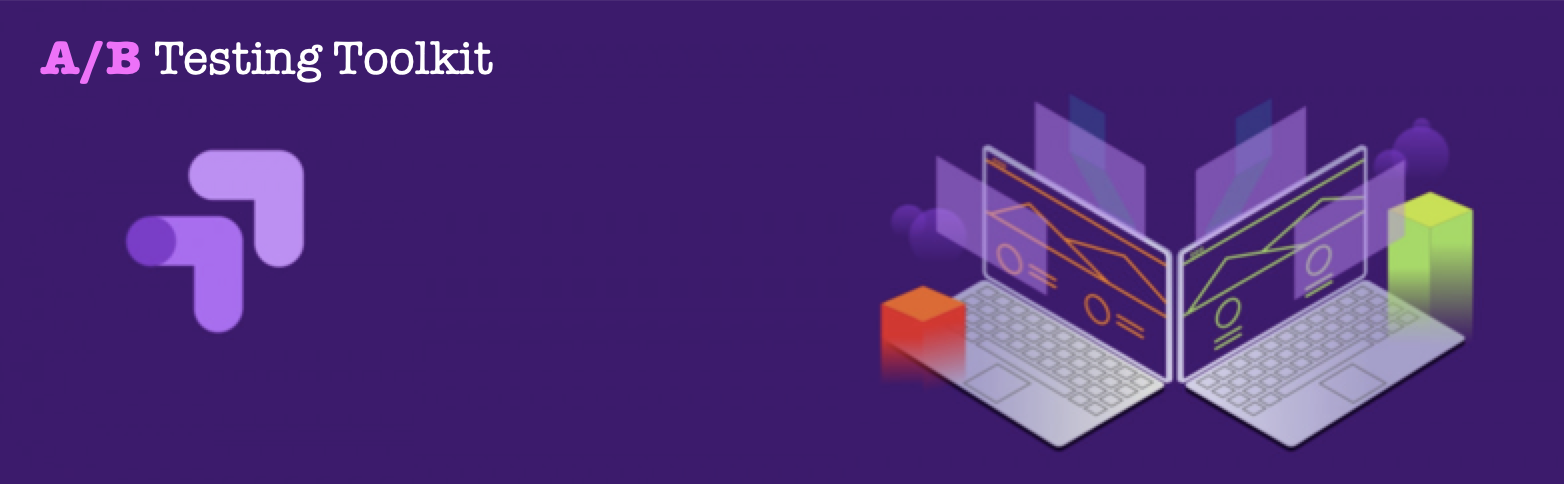

# Bayesian Conversion Probability (A/B Testing Framework)

## Method 1

In [124]:
from scipy.stats import beta
import numpy as np
from math import lgamma
from numba import jit
from mpmath import betainc
import seaborn as sb
import pandas as pd
from matplotlib import pyplot as plt
import warnings

In [125]:
## Turn off warnings

warnings.filterwarnings("ignore")

In [126]:
# Calculate probability between code - taken from calc_prob

@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [127]:
## Input the number of unique visitors/cookie units for the control and variant respectively

n_control = 164246

n_variant = 164206

In [128]:
## Input the number of unique events fired for the control and variant respectively 

e_control = 7883

e_variant = 8374

In [129]:
## Calculate beta functions for both control and variant respectively

## Control ##

a_control = e_control + 1
b_control = n_control - (e_control + 1)
beta_control = beta(a_control, b_control)

## Variant ##

a_variant = e_variant + 1
b_variant = n_variant - (e_variant + 1)
beta_variant = beta(a_variant, b_variant)

In [130]:
## Calcuate the uplift

uplift = (beta_variant.mean() - beta_control.mean())/beta_control.mean()
print("The relative uplift/decrease between the variant and control is:",round(uplift*100,4),"%")

The relative uplift/decrease between the variant and control is: 6.2537 %


In [131]:
## Calculate the probability for test to be better than the control

prob = calc_prob_between(beta_variant, beta_control)
print("The probability that the variant beat the control is:",round(prob*100,4),"%")

The probability that the variant beat the control is: 99.9963 %


In [143]:
## Input desired thresholds to observe

threshold = 0.03
prob_threshold = betainc(a_variant, b_variant, threshold,1, regularized=True)
print("The probabilty that the conversion rate of the variant is greater than",threshold,"is",round(100 * prob_threshold,4),"%")

ValueError: hypsum() failed to converge to the requested 186 bits of accuracy
using a working precision of 3701 bits. Try with a higher maxprec,
maxterms, or set zeroprec.

# Visualisations

The conversion probabilty of the control group is: 4.7995 %
The conversion probabilty of the variant group is: 5.0997 %
The probability that the variant beat the control is: 99.9963 %


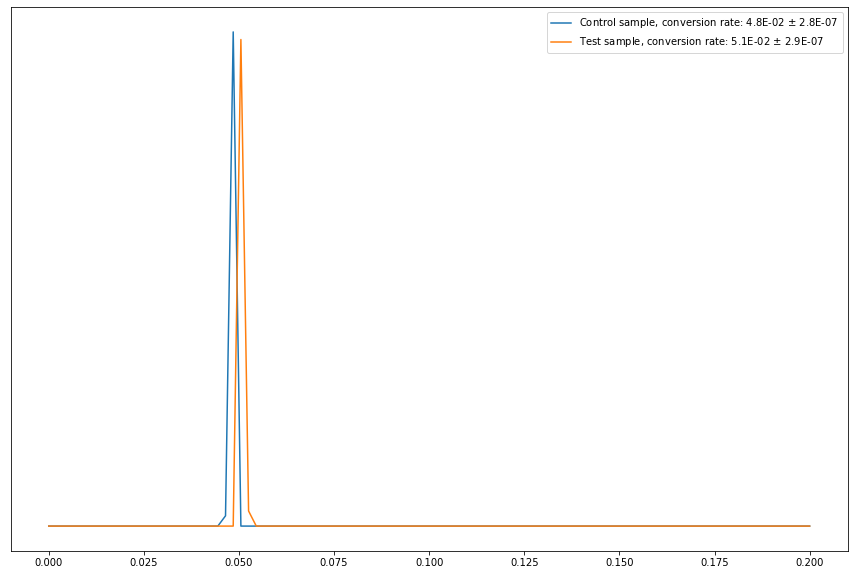

In [144]:
## Plot the probability distributions of both experimental conditions

def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

## Set figure size

plt.figure(figsize=(15,10))

def plot(betas, names, linf=0, lsup=0.2):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) # This for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # The variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()
    plt.show()

## Calculate conversion probability for the control and variant respectively

## Control

conv_control = e_control / n_control

## Variant

conv_variant = e_variant / n_variant

## Print conversion rates/probabilities for control and variant and the probability that the variant beat the control

print("The conversion probabilty of the control group is:",round(100 * conv_control,4),"%")
print("The conversion probabilty of the variant group is:",round(100 * conv_variant,4),"%")
print("The probability that the variant beat the control is:",round(prob*100,4),"%")

plot([beta_control, beta_variant], names=["Control", "Test"])


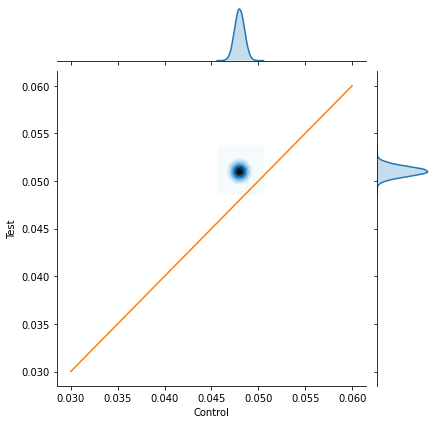

In [162]:
##### Here we create the Beta functions for the two sets

a_control, b_control = e_control + 1, n_control - e_control + 1
a_variant, b_variant = e_variant + 1, n_variant - e_variant + 1

val_control = np.random.beta(a_control, b_control, 100000)
val_variant = np.random.beta(a_variant, b_variant, 100000)
vals = np.vstack([val_control, val_variant]).T


## Set limit for axis

limit=0.06

## Create data-frame with simulations and plot joint probability distribution

df = pd.DataFrame(vals, columns=['Control', 'Test'])
df = df[df['Control'] < limit]
df = df[df['Test'] < limit]
g = sb.jointplot(x = df.Control, y = df.Test, kind = 'kde', n_levels = 20)
g.ax_joint.plot([0.03, limit], [0.03, limit])

## Method 2 (adapted from thibalbo - https://github.com/thibalbo/bayesian-abtests-examples)

In [147]:
%matplotlib inline
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False

In [148]:
## Input the number of unique visitors/cookie units for the control and variant respectively

n_control = 164246

n_variant = 164206

In [149]:
## Input the number of unique events fired for the control and variant respectively 

e_control = 7883

e_variant = 8374

In [157]:
## Instantiate model and set prior and likelihood

with pm.Model() as model: # context management
    
    # define priors (use the control pirior as the null hypothesis is that no difference exists between variants)
    
    prior_control = pm.Beta('prior_control', alpha = e_control, beta = n_control - e_control)
    prior_variant = pm.Beta('prior_variant', alpha = e_variant, beta = n_variant - e_variant)

    # define likelihood
    
    likelihood_control = pm.Binomial('like_control', n = 164246, p = prior_control, observed = e_control)
    likelihood_variant = pm.Binomial('like_variant', n = 164206, p = prior_variant, observed = e_variant)
    
    # define metrics
    
    pm.Deterministic('absolute difference', prior_variant - prior_control)
    pm.Deterministic('relative difference', (prior_variant / prior_control) - 1)

    # inference using MCMC
    trace = pm.sample(draws = 10000, step = pm.Metropolis(), start = pm.find_MAP(), progressbar=True)

logp = 2.4384, ||grad|| = 4.6806e-05: 100%|██████████| 21/21 [00:00<00:00, 4698.37it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [prior_variant]
>Metropolis: [prior_control]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:05<00:00, 7993.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


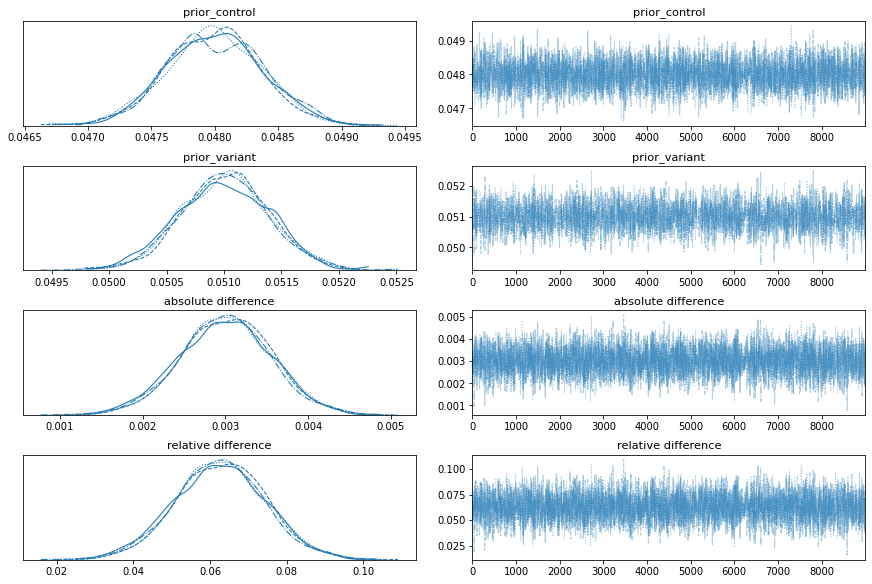

In [158]:
## Plot posterior distributions for variants and both differences

_ = pm.traceplot(trace[1000:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x138e37810>,
      dtype=object)

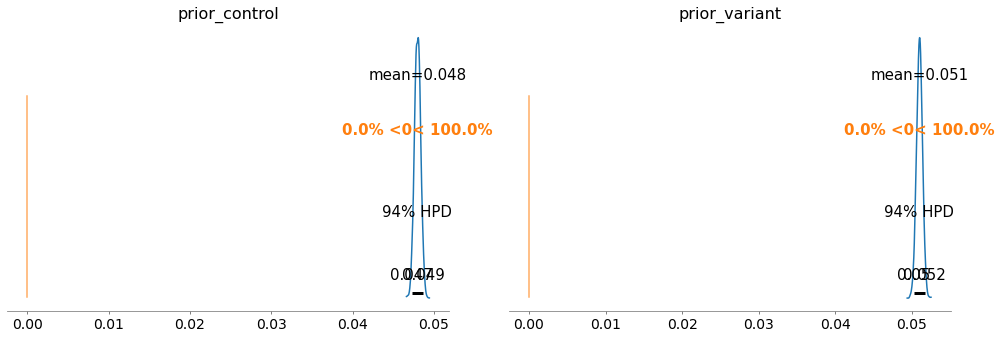

In [159]:
## Plot posterior distributions for control and variant

pm.plot_posterior(trace, var_names=['prior_control', 'prior_variant'], 
                      ref_val=0)

The absolute uplift/decrease between the variant and control is: 0.3002 %
The relative uplift/decrease between the variant and control is: 6.2545 %


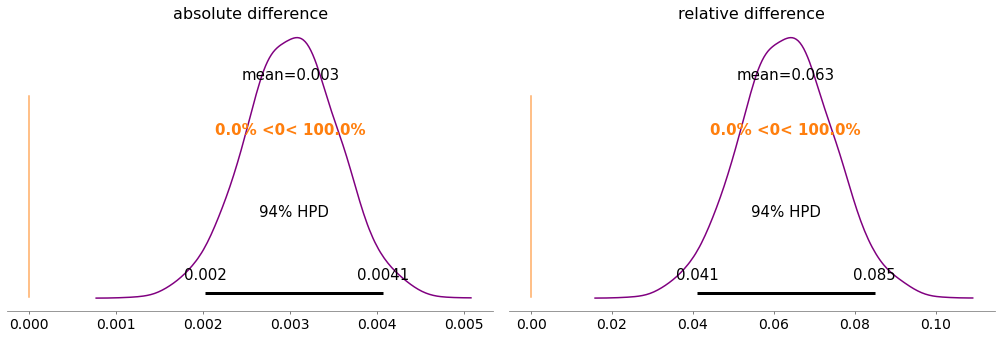

In [160]:
## Plot mean difference and relation between experimentqal conditions with uplift

## Absolute and relative difference

## Conversion rates/probabilities

conv_control = e_control / n_control
conv_variant = e_variant / n_variant

# Difference and uplift


exp_diff = conv_variant - conv_control
exp_uplift = conv_variant/conv_control -1


# Print results

print("The absolute uplift/decrease between the variant and control is:",round(exp_diff * 100, 4),"%")
print("The relative uplift/decrease between the variant and control is:",round(exp_uplift * 100,4),"%")

## Probability distribution of absolute and relative difference

_ = pm.plot_posterior(trace[1000:], varnames=['absolute difference', 'relative difference'], 
                      ref_val=0, color='purple')